# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    load_parquet_subset,
    perturbation_filter,
    visualize_nas,
    intensity_filter,
    missing_values_filter,
)
from lib.aggregate.align import prepare_alignment_data, pca_variance_plot, embed_by_pca, tvn_on_controls
from lib.aggregate.collapse_data import collapse_to_sgrna, collapse_to_gene
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL`: Well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL = "A1"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=50000)
display(cell_data)

print("First 20 columns; use to set parameters below.")
for index, col in enumerate(cell_data.columns[:20]):
    print(index, col)

Reading first 50,000 rows from analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,429,1478.403947,1481.714474,243,254,100.607843,670.117647,...,0,0.000000,48.501317,54.812638,164.492958,0.0,0.000000,48.482563,55.773102,160.427741
1,1,A1,401,485,1477.766431,1478.877654,101,294,100.089552,669.910448,...,1,0.049751,45.269871,62.882030,106.480590,1.0,0.028818,40.760186,57.586665,116.482954
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
3,1,A1,595,475,1480.676399,1482.874696,154,221,100.764706,670.764706,...,2,0.193548,36.794933,52.151249,171.453465,2.0,0.040404,39.327858,47.072292,154.575718
4,1,A1,1479,601,1477.695030,1481.850904,365,346,99.764045,671.494382,...,0,0.000000,57.697175,61.333366,138.748450,0.0,0.000000,62.644570,63.731803,133.933684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1125,453,1480.076923,1755.965545,278,220,100.432099,168.814815,...,1,0.027778,51.719049,57.920520,168.921134,1.0,0.015625,52.825726,62.730908,168.160355
49996,1,A1,1408,731,1753.173077,1440.839744,338,2338,739.098765,92.271605,...,0,0.000000,63.654194,75.970693,59.774914,0.0,0.000000,65.328179,79.941206,91.112332
49997,1,A1,525,334,1227.967429,1592.447678,120,1347,608.121212,697.919192,...,0,0.000000,52.176829,59.403882,169.852034,0.0,0.000000,49.825625,59.247234,172.702028
49998,1,A1,56,503,1600.628225,1728.227618,19,350,130.087379,160.582524,...,0,0.000000,60.944246,69.059469,44.366065,0.0,0.000000,62.061594,64.824308,55.486461


First 20 columns; use to set parameters below.
0 plate
1 well
2 tile
3 cell_0
4 i_0
5 j_0
6 site
7 cell_1
8 i_1
9 j_1
10 distance
11 fov_distance_0
12 fov_distance_1
13 sgRNA_0
14 gene_symbol_0
15 mapped_single_gene
16 channels_min
17 nucleus_DAPI_int
18 nucleus_COXIV_int
19 nucleus_CENPA_int


## <font color='red'>SET PARAMETERS</font>

### Split cells into types

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes
- `FEATURE_START_IDX`: Index of first feature in cell data (see first 20 cols above). Usually `17`

**Note**: Any Python packages necessary for the loaded cell classifier must be imported here as well.

In [5]:
CLASSIFIER_PATH = "config/naive_mitotic_classifier.pkl"
FEATURE_START_IDX = 17

In [ ]:
import numpy as np
classifier = CellClassifier.load(CLASSIFIER_PATH)
classes, confidences = classifier.classify_cells(cell_data, FEATURE_START_IDX)

# Insert the arrays as new columns before the feature columns
cell_data.insert(FEATURE_START_IDX, "class", classes)
cell_data.insert(FEATURE_START_IDX + 1, "confidence", confidences)

# Update FEATURE_START_IDX
FEATURE_START_IDX += 2

# Create config var for cell classes
CELL_CLASSES = list(cell_data["class"].unique())

cell_data[['class', 'confidence']]

,class,confidence
0,interphase,0.071531
1,interphase,0.297538
2,interphase,0.674813
3,interphase,0.641099
4,interphase,0.006422
...,...,...
49995,interphase,0.626818
49996,interphase,0.720488
49997,interphase,0.725264
49998,interphase,0.846307


Subsetting 272 mitotic cells and 49728 interphase cells


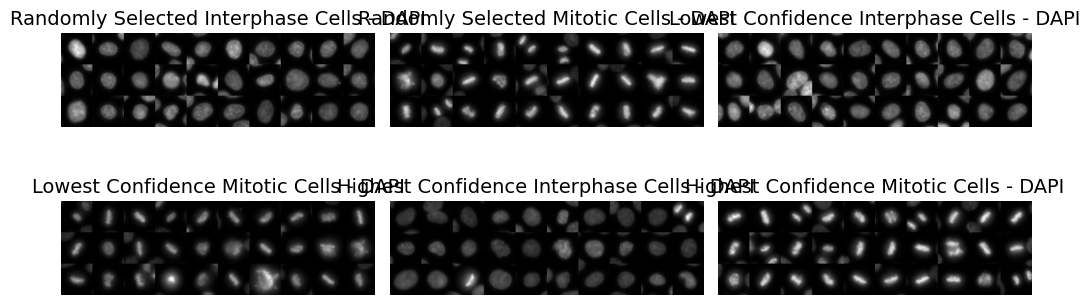

In [ ]:
classified_cell_data = cell_data.copy()
classified_cell_data = add_filenames(classified_cell_data, ROOT_FP)

# Use final thresholding to split cells
mitotic_df = classified_cell_data[classified_cell_data["class"] == "mitotic"]
interphase_df = classified_cell_data[classified_cell_data["class"] == "interphase"]
print(
    f"Subsetting {len(mitotic_df)} mitotic cells and {len(interphase_df)} interphase cells"
)

# Create figure to evaluate DAPI cutoff

titles = [
    "Randomly Selected Interphase Cells - DAPI",
    "Randomly Selected Mitotic Cells - DAPI",
    "Lowest Confidence Interphase Cells - DAPI",
    "Lowest Confidence Mitotic Cells - DAPI",
    "Highest Confidence Interphase Cells - DAPI",
    "Highest Confidence Mitotic Cells - DAPI",
]

# Get channels from config
CHANNELS = config["phenotype"]["channel_names"]
montages = [
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": True,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": True,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": False,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": False,
        },
    )["DAPI"],
]

# Initialize figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

# Display each montage
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `PERTURBATION_NAME_COL`: Name of column used to identify perturbation
- `PERTURBATION_MULTI_COL`: Name of column that has a boolean flag for if multiple perturbations are detected
- `FILTER_SINGLE_PERT`: Whether or not to only keep cells that have a single perturbation

In [ ]:
PERTURBATION_NAME_COL = "gene_symbol_0"
PERTURBATION_MULTI_COL = "mapped_single_gene"
FILTER_SINGLE_PERT = False

perturbation_filtered = perturbation_filter(
    cell_data, PERTURBATION_NAME_COL, PERTURBATION_MULTI_COL, FILTER_SINGLE_PERT
)
print(f"Unique populations: {perturbation_filtered[PERTURBATION_NAME_COL].nunique()}")

fig = visualize_nas(perturbation_filtered)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Missing value and intensity filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`

In [ ]:
DROP_COLS_THRESHOLD = 0.1

In [ ]:
missing_values_filtered = missing_values_filter(
    perturbation_filtered, FEATURE_START_IDX, drop_cols_threshold=DROP_COLS_THRESHOLD
)

# Load channel names
channel_names = config["phenotype"]["channel_names"]
intensity_filtered = intensity_filter(
    perturbation_filtered, FEATURE_START_IDX, channel_names
)

intensity_filtered

## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`

In [ ]:
BATCH_COLS = ["plate", "well"]

In [ ]:
features, metadata = prepare_alignment_data(missing_values_filtered, BATCH_COLS, FEATURE_START_IDX)

pca_df_threshold, n_components, pca, fig = pca_variance_plot(features, variance_threshold=0.95)

print("Top 10 pertubration counts:")
metadata[PERTURBATION_NAME_COL].value_counts()[:10]

## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `PC_COUNT`: Number of principal components to use when creating embeddings with PCA (see figure above). Usually the amount of principal components needed to explain 95% of variance (see above).
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.

In [ ]:
PC_COUNT = 428
CONTROL_KEY = "nontargeting"

In [ ]:
pca_embeddings = embed_by_pca(features.values, metadata, variance_or_ncomp=PC_COUNT, batch_col="batch_values")
tvn_normalized = tvn_on_controls(pca_embeddings, metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values")

tvn_normalized_columns = [f'PCA_{i}' for i in range(tvn_normalized.shape[1])]
tvn_normalized_df = pd.DataFrame(tvn_normalized, index=metadata.index, columns=tvn_normalized_columns)
aligned_cell_data = pd.concat([metadata, tvn_normalized_df], axis=1)

aligned_cell_data

In [ ]:
import numpy as np

def aggregate(
    embeddings: np.ndarray,
    metadata: pd.DataFrame,
    pert_col: str,
    keys_to_remove: list[str] = [],
    method="mean",
) -> Bunch[pd.DataFrame, pd.DataFrame]:
    """
    Apply the mean or median aggregation to replicate embeddings for each perturbation.
    Note that this function resets the index of the metadata DataFrame so that we can access groups
    in embeddings by index.

    Args:
        embeddings (numpy.ndarray): The embeddings to be aggregated.
        metadata (pandas.DataFrame): The metadata containing information about the embeddings.
        pert_col (str, optional): The column in the metadata containing perturbation information.
        method (str, optional): The aggregation method to use. Must be either "mean" or "median".
            Defaults to "mean".

    Returns:
        Bunch: A named tuple containing two pandas DataFrames:
            - 'features': The aggregated embeddings.
            - 'metadata': A DataFrame containing the perturbation labels for each row in 'data'.
    """
    final_embeddings = []
    metadata = metadata.reset_index(drop=True)
    aggr_func = np.mean if method == "mean" else np.median if method == "median" else None
    if aggr_func is None:
        raise ValueError(f"Invalid aggregation method: {method}")
    grouping = metadata.groupby(pert_col)
    unique_perts = []
    for pert, group in grouping:
        if pert in keys_to_remove:
            continue
        final_emb = aggr_func(embeddings[group.index.values, :], axis=0)
        final_embeddings.append(final_emb)
        unique_perts.append(pert)
    return Bunch(
        features=pd.DataFrame(np.vstack(final_embeddings)), metadata=pd.DataFrame.from_dict({pert_col: unique_perts})
    )


## Add aggregate parameters to config file

In [ ]:
# # Add aggregate section
# config["aggregate"] = {
#     "perturbation_name_col": PERTURBATION_NAME_COL,
#     "perturbation_multi_col": PERTURBATION_MULTI_COL,
#     "filter_single_pert": FILTER_SINGLE_PERT,
#     "feature_start_idx": FEATURE_START_IDX,
#     "drop_cols_threshold": DROP_COLS_THRESHOLD,
#     "batch_cols": BATCH_COLS,
#     "pc_count": PC_COUNT,
#     "control_key": CONTROL_KEY,
# }

# # Write the updated configuration
# with open(CONFIG_FILE_PATH, "w") as config_file:
#     # Write the introductory comments
#     config_file.write(CONFIG_FILE_HEADER)

#     # Dump the updated YAML structure, keeping markdown comments for sections
#     yaml.dump(config, config_file, default_flow_style=False)